### Part 1 Loading and examining the dataset

In [1]:
import os
from helper import *
from classification import DecisionTreeClassifier
from DecisionTreeWithPruning import DecisionTreeWithPruning
from improvement import train_and_predict

#### Question 1.1

From the graph below, we can see the class samples are unbalanced in train_sub, in comparison to train_full dataset. The proportion of data for G and Q classes are much smaller and the proportion of data for C class is much larger.

In [2]:
dataset = ["train_full", "train_sub", "train_noisy"]

Reading in file train_full
A appeared 667 times, 0.17 of the total set
C appeared 599 times, 0.15 of the total set
E appeared 659 times, 0.17 of the total set
G appeared 671 times, 0.17 of the total set
O appeared 637 times, 0.16 of the total set
Q appeared 667 times, 0.17 of the total set
Reading in file train_sub
A appeared 94 times, 0.16 of the total set
C appeared 187 times, 0.31 of the total set
E appeared 129 times, 0.22 of the total set
G appeared 21 times, 0.04 of the total set
O appeared 113 times, 0.19 of the total set
Q appeared 56 times, 0.09 of the total set
Reading in file train_noisy
A appeared 681 times, 0.17 of the total set
C appeared 571 times, 0.15 of the total set
E appeared 678 times, 0.17 of the total set
G appeared 622 times, 0.16 of the total set
O appeared 666 times, 0.17 of the total set
Q appeared 682 times, 0.17 of the total set


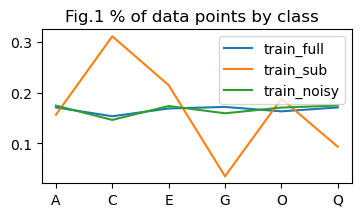

In [25]:
labelSummarySet = []
labelSet = []
featureset = []
labelFig, labelAx = plt.subplots()
labelFig.suptitle("Fig.1 % of data points by class")
labelFig.set_figwidth(4)
labelFig.set_figheight(2)
for data in dataset:
    path = os.path.join("data", data + ".txt")
    feature, label = read_data(path)
    print(f"Reading in file {data}")
    labelSummary = label_analyse(label, data, labelAx)  
    labelSummarySet.append(labelSummary)
    labelSet.append(label)
    featureset.append(feature)

#### Question 1.2 

The attributes provided in the dataset are discrete variables and all are type of integers. The ranges of each attribute in train_full are as following:

In [4]:
classes, indices = np.unique(labelSet[0], return_inverse=True)

for feature 0:
          range is between 0 and 10   mode: 4   
          standard deviation: 1.710099      median: 4.0
for feature 1:
          range is between 0 and 15   mode: 9   
          standard deviation: 3.305896      median: 7.0
for feature 2:
          range is between 1 and 11   mode: 5   
          standard deviation: 1.67762      median: 5.0
for feature 3:
          range is between 0 and 12   mode: 6   
          standard deviation: 2.272632      median: 6.0
for feature 4:
          range is between 0 and 14   mode: 2   
          standard deviation: 1.96102      median: 3.0
for feature 5:
          range is between 2 and 14   mode: 7   
          standard deviation: 1.815799      median: 7.0
for feature 6:
          range is between 0 and 14   mode: 7   
          standard deviation: 1.886738      median: 7.0
for feature 7:
          range is between 0 and 10   mode: 6   
          standard deviation: 1.998248      median: 6.0
for feature 8:
          range is between 

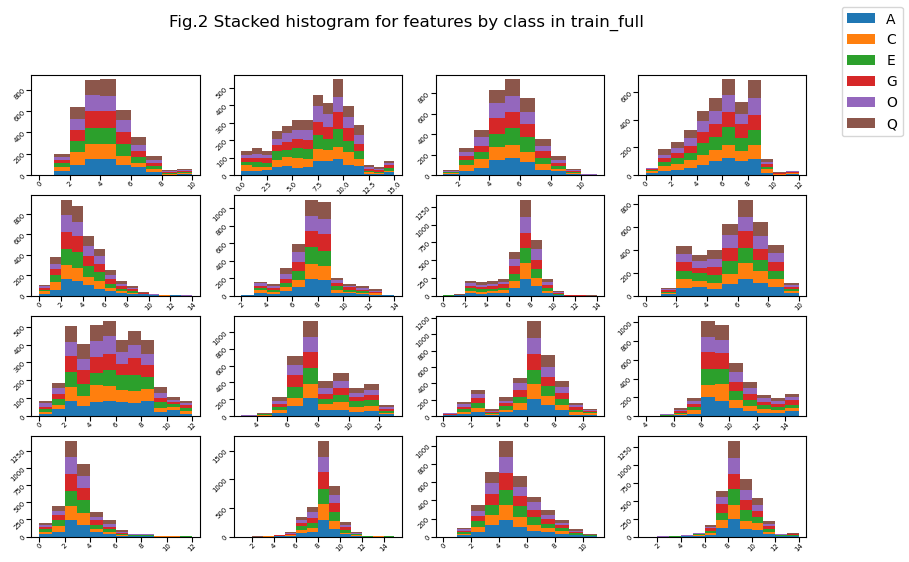

In [18]:
featureFig, featureAx = plt.subplots(4, 4, figsize=(10,6))
featureFig.suptitle(f"Fig.2 Stacked histogram for features by class in train_full")
for col in range(feature.shape[1]):
    featureData = feature[:,col]
    print(f"""for feature {col}:
          range is between {min(featureData)} and {max(featureData)}   mode: {stats.mode(featureData)[0][0]}   
          standard deviation: {round(featureData.std(axis=0), 6)}      median: {np.median(featureData)}""") 
    row = int(col/4)
    column = int(col%4)
    perClassFeature = []
    for class_idx in range(len(classes)):
        perClassFeature.append(featureData[indices==class_idx])
    
    n, bins, patche = featureAx[row, column].hist(perClassFeature, bins=np.unique(featureData), stacked=True, label=classes)
    featureAx[row, column].tick_params(axis='both', which='major', labelsize=5, pad=0, rotation=45)

handles, labels = featureAx[0,0].get_legend_handles_labels()
featureFig.legend(handles, labels)
# featureFig.savefig(f"Feature Graph for {data}.png", dpi=1600)

#### Question 1.3 

In [6]:
#combining feature and label data
train_full = np.concatenate((featureset[0], labelSet[0].reshape(len(labelSet[0]),1)), axis=1)
train_noisy = np.concatenate((featureset[2], labelSet[2].reshape(len(labelSet[2]),1)), axis=1)
#prepare sorting keys
lexsortKeyFull = tuple([train_full[:,i] for i in range(15, -1, -1)])
lexsortKeyNoisy = tuple([train_noisy[:,i] for i in range(15, -1, -1)])
#sort by each column, 1st column as primary, 2nd as secondary....
train_full = train_full[np.lexsort(lexsortKeyFull)]
train_noisy = train_noisy[np.lexsort(lexsortKeyNoisy)]

In [7]:
rowComparison = np.sum(train_full==train_noisy, axis=1)
diffCount = np.sum(rowComparison != 17)
print(f"There are {diffCount} rows having different labels in train_full & train_noisy, representing {round(diffCount/len(train_full)*100,2)}% of the samples.")

There are 598 rows having different labels in train_full & train_noisy, representing 15.33% of the samples.


From Fig.1, the proportion of each class within the sample stayed roughly the same, thus the class distribution has not been affected.\
Considering the classes for which the proportion in total samples have changed by more than 0.5% across train_full and train_noisy, we observe that:
- classes C & O have slightly larger number of samples in train_noisy compared to train_full; 
- class G has a smaller number of samples in train_noisy compared to train_full.

### Part 2 Implementing decision trees

#### Task 2.1


A binary tree is chosen since all the attributes of the dataset are integers.

The decision tree classifier has an attribute called `_rootNode` which allows access to the topmost node in the tree. Since it is a binary tree classifier, each decision node has two branches, `leftNode` and `rightNode`. Each node stores the evaluated feature `feature` and the splitting threashold `splitPoint`. If a final node of the tree is reached, the attribute `isLeaf` will be set to true and the attribute `classLabel` will store the value of its category of this leaf Node.

The decision tree is built top-down from a root node by finding an feature and its corresponding splitting threashold that return the highest information gain. The method `__find_best_split_point()` iterates through each possible feature and threashold and selects the combination that maximizes the information gain.
 
The splitting process will be stopped if:
* All the data points in a node belong to the same category.
*  The data points in a node have repeated values for each feature, which means $X_{i,l} = X_{j,l}$ for all $i, j \in {1, 2, ... , N}$ and $l \in {1, 2, ... , K}$, where $i$, $j$ are data indices, $l$ is feature index, $N$ is the number of data points and $K$ is the number of features.
*  A certain depth of the tree is reached.
*  A certain number of training sample required to split an node is reached.

In this section, only the first two conditions are considered, and the latter two conditions will be discussed in detail in section 4.

Since Fig.2 shows that all the attributes fall within a similar range of values and appear to follow a normal distribution pattern, the training data is not pre-processed, e.g. standardized or normalized.

#### Task 2.2


The `predict()` method takes an array of test samples and loops over each sample to get its predicted class label by calling the `__predict_one_sample()` method. This method takes a node and a sample as inputs and returns the predicted category. It navigates from a root node to leaf nodes and implements the following steps in a recursive manner.

If the current node is a leaf node, the `classLabel` is returned. Otherwise, the feature value of the sample is evaluated. If the feature value is less than the `splitPoint`, the left child node is traversed. Otherwise, the right child node is traversed. This process is repeated until a leaf node is reached.

### Part 3: Evaluation

In [20]:
files = [os.path.join("data",i) for i in dataset]
confusion_dt, rec, prec, f1 = [],[],[],[]
acc, macro_rec, macro_prec, macro_f1 = np.zeros(len(files)), np.zeros(len(files)), np.zeros(len(files)), np.zeros(len(files))

In [21]:
(x_test,y_test) = read_data("./data/test.txt")

In [22]:
for i in range(len(dataset)):
    filepath = os.path.join("data", dataset[i] +".txt")
    (x_train,y_train) = read_data(filepath)

    tree = DecisionTreeClassifier()
    rootNode = tree.fit(x_train,y_train)
    y_predict = tree.predict(x_test)
    
    # Compute confusion matrix on predictions
    confusion_dt.append(confusion_matrix(y_test, y_predict))
    # Compute accuracy on predictions
    acc[i] = accuracy(y_test, y_predict)
    # Compute Recall, Precision, and F1 score per class
    rec_list, macro_rec[i] = recall(y_test, y_predict)
    prec_list, macro_prec[i] = precision(y_test, y_predict)
    f1_list, macro_f1[i]  = f1_score(y_test, y_predict)
    rec.append(rec_list)
    prec.append(prec_list)
    f1.append(f1_list)

    #explore which classes are often confused (as which classes)
    if (i == 0):
        classG, countG = np.unique(y_predict[(y_test == 'G') & (y_test != y_predict)], return_counts = True)
        classQ, countQ = np.unique(y_predict[(y_test == 'Q') & (y_test != y_predict)], return_counts = True)

print(classG, countG)  #check class 'G' is often confused as which class
print(classQ, countQ)  #check class 'Q' is often confused as which class

['A' 'C' 'E' 'Q'] [1 1 3 3]
['E' 'O'] [2 5]


In [23]:
classlabels = np.unique(y_train)
for idx, data in enumerate(dataset):
    print(f"""Considering model trained on {data}:  
        Confusion matrix is {confusion_dt[idx]}
        Accuracy of model is {acc[idx]}
        Recall of each class is {rec[idx]}
        Precision of each class is {prec[idx]}
        F1-score of each class is {f1[idx]}
        Macro-averaged recall is {round(macro_rec[idx],4)}
        Macro-averaged precision is {round(macro_prec[idx],4)}
        Macro-averaged F1 score is {round(macro_f1[idx],4)}""")   
    print(f"Incorrect predictions / Number of correct predictions / Incorrect prediction rate")
    for i in range(len(classlabels)):
        print(f"""\tfor class {classlabels[i]}: {np.sum(confusion_dt[idx][i]) - confusion_dt[idx][i][i]}  / {confusion_dt[idx][i][i]} / {np.round(100* (np.sum(confusion_dt[idx][i]) - confusion_dt[idx][i][i]) / np.sum(confusion_dt[idx][i]), 2)}%""")
    print("-"*50)

Considering model trained on train_full:  
        Confusion matrix is [[33  0  0  1  0  0]
 [ 1 33  2  1  0  0]
 [ 0  0 24  0  1  1]
 [ 1  1  3 19  0  3]
 [ 0  2  0  1 31  0]
 [ 0  0  2  0  5 35]]
        Accuracy of model is 0.875
        Recall of each class is [0.97058824 0.89189189 0.92307692 0.7037037  0.91176471 0.83333333]
        Precision of each class is [0.94285714 0.91666667 0.77419355 0.86363636 0.83783784 0.8974359 ]
        F1-score of each class is [0.95652174 0.90410959 0.84210526 0.7755102  0.87323944 0.86419753]
        Macro-averaged recall is 0.8724
        Macro-averaged precision is 0.8721
        Macro-averaged F1 score is 0.8693
    
Incorrect predictions / Number of correct predictions / Incorrect prediction rate
	for class A: 1  / 33 / 2.94%
	for class C: 4  / 33 / 10.81%
	for class E: 2  / 24 / 7.69%
	for class G: 8  / 19 / 29.63%
	for class O: 3  / 31 / 8.82%
	for class Q: 7  / 35 / 16.67%
--------------------------------------------------
Considering mode

#### Which one performs the best? The worst? Give some insights into why.
The model trained with train_full.txt performs the best, with an accuracy of 0.875, macro-averaged recall of 0.8724, macro-averaged precision of 0.8721, macro-averaged F1 score of 0.8693.
The model trained with train_sub.txt performs the worst, with an accuracy of 0.7, macro-averaged recall of 0.6906, macro-averaged precision of 0.6869, macro-averaged F1 score of 0.6769.
- The less data, the more prone to overfitting, thus the number of samples in train_sub limits the performance of the model on test data.
- In addition, the data points in train_sub are imbalanced across class, e.g. there are much fewer data points for class G. Thus the trained decision tree could not 'learn' much about this specific class, resulting in a poorer recall in comparison to other classes in train_sub.

#### Which classes are accurate? Which classes are often confused? Which classes are they often confused as? Explain.
In the model trained with train_full.txt, class A is the most accurate, with a recall of 0.97, precision of 0.94, f1-score of 0.96. The incorrect predictions / number of correct predictions are respectively 1  / 33; The incorrect prediction rate is 2.94%, which is the lowest among all classes.

In the model trained with train_full.txt, class G is often confused, with a recall of 0.70, precision of 0.86, f1-score of 0.78. The incorrect predictions / number of correct predictions are respectively 8  / 19; The incorrect prediction rate is 29.63%, which is the highest among all classes. It is often confused as class 'E' and class 'Q', as it's mistaken as 'E' or 'Q' for 3 times each; Q is also often confused as O, as it's mistaken as 'O' for 5 times.

#### Question 3.2
Perform 10-fold cross validation on train full.txt. You can use the cross validation code from the lab tutorials.

Report the average accuracy across the 10 folds. Also report the standard deviation of the accuracies. For example, 0:7854 +/- 0:0122. What does it mean to have a small/large standard deviation in this context?

In [12]:
x, y = read_data("./data/train_full.txt")
n_folds = 10
accuracies = np.zeros((n_folds, ))
seed = 12345
rg = default_rng(seed)

for i, (train_indices, test_indices) in enumerate(train_test_k_fold(n_folds, len(x), rg)):
    # get the dataset from the correct splits
    x_train = x[train_indices, :]
    y_train = y[train_indices]
    x_test = x[test_indices, :]
    y_test = y[test_indices]
    # Train the Decision Tree
    tree = DecisionTreeClassifier()
    rootNode = tree.fit(x_train,y_train)
    y_predict = tree.predict(x_test)
    accuracies[i] = accuracy(y_test, y_predict)
print(accuracies)
print(f"the accuracy across the 10 folds is {round(accuracies.mean(),4)} +/- {round(accuracies.std(),4)}")

[0.94103 0.88974 0.91795 0.90769 0.90256 0.91282 0.89487 0.91282 0.93333
 0.89231]
the accuracy across the 10 folds is 0.9105 +/- 0.0161


Small standard deviation suggests that the model performance in terms of accurancy is consistent across different folds; this implies the data is shuffled well, so there isn't a single tree that is more under/overfit than others.

#### Question 3.3

In [13]:
X_test,Y_test = read_data("./data/test.txt")
Y_predicts = []
seed = 12345
rg = default_rng(seed)
accuracies = np.zeros((n_folds, ))
for i, (train_indices, test_indices) in enumerate(train_test_k_fold(n_folds, len(x), rg)):
    # get the dataset from the correct splits
    x_train = x[train_indices, :]
    y_train = y[train_indices]
    x_test = x[test_indices, :]
    y_test = y[test_indices]
    # Train the Decision Tree
    tree = DecisionTreeClassifier()
    rootNode = tree.fit(x_train,y_train)
    Y_predicts.append(tree.predict(X_test)) 

Y_prediction_by_mode = np.empty((len(Y_test), ), dtype = Y_test.dtype)
for i in range(len(Y_prediction_by_mode)):
    d_freq = dict.fromkeys(['A', 'C', 'E', 'G', 'O', 'Q'], 0)
    for fold_j in range(n_folds):
        d_freq[Y_predicts[fold_j][i]] += 1
    Y_prediction_by_mode[i] = max(d_freq, key = d_freq.get)
acc = accuracy(Y_test, Y_prediction_by_mode)
print(acc)

0.905


The accuracy of model trained on full set of train_full.txt is 0.875; 0.905 indicates a small improvement in the accurancy. 

One possible explaination is that the mode is not affected by extreme values; if there are some abnormal data points, while they could affect the training process in a single decision tree, the prediction from that specific tree will be overruled by the prediction from other trees, which are trained with 'normal' data points. Besides, k-fold cross validation could prevent the overfitting of the training data set.

### Part 4: Improving your decision tree

#### Task 4.1
The proposed improvement includes a pruning process where we try limiting the growth of the tree with 3 hyperparameters:
- max_depth: maximum depth of decision tree
- min_sample_split: The minimum number of samples required to split an internal node
- min_samples_leaf: The minimum number of samples required to be at a leaf node

This is motivated by the observation from the original tree which had a few leaf nodes with limited samples.

In the implementation, these 3 hyperparameters are jointly selected based on accuracies of prediction against validation set. Given the sample size from validation set is rather limited and the slight imbalance in the class labels, instead of choosing the combination giving the best performance, we take the models with better performance which is defined as top 10% and apply a bagging process, so that the predicted class for each sample is the mode of predictions given by these decision trees. Similar to qn3.3 above, we hope to leverage this process to reduce the variance of the model.

#### Question 4.1

In [15]:
x_test, y_test = read_data("./data/test.txt")
x_val, y_val = read_data("./data/validation.txt")

for file in ["./data/train_full.txt", "./data/train_noisy.txt"]:
    print(f"Model trained with {file}:")
    x_train, y_train = read_data(file)
    y_predict = train_and_predict(x_train, y_train, x_test, x_val, y_val)
    print(f"""Confusion matrx: {confusion_matrix(y_test, y_predict)}
        Accuracy: {accuracy(y_test, y_predict)}
        Recall / Macro_averaged Recall {recall(y_test, y_predict)}
        Precision / Macro_averaged Precision {precision(y_test, y_predict)}
        F1 score / Macro_averaged F1 {f1_score(y_test, y_predict)}""")

Model trained with ./data/train_full.txt:
Confusion matrx: [[33  0  0  1  0  0]
 [ 0 34  2  1  0  0]
 [ 0  0 25  0  1  0]
 [ 1  1  0 22  0  3]
 [ 0  2  0  1 31  0]
 [ 0  0  3  0  7 32]]
        Accuracy: 0.885
        Recall / Macro_averaged Recall (array([0.97058824, 0.91891892, 0.96153846, 0.81481481, 0.91176471,
       0.76190476]), 0.8899216497255713)
        Precision / Macro_averaged Precision (array([0.97058824, 0.91891892, 0.83333333, 0.88      , 0.79487179,
       0.91428571]), 0.8853329994506466)
        F1 score / Macro_averaged F1 (array([0.97058824, 0.91891892, 0.89285714, 0.84615385, 0.84931507,
       0.83116883]), 0.8848336738143346)
Model trained with ./data/train_noisy.txt:
Confusion matrx: [[32  0  0  0  1  1]
 [ 1 31  0  4  1  0]
 [ 0  0 23  3  0  0]
 [ 0  1  0 16  0 10]
 [ 1  1  1  0 29  2]
 [ 1  0  3  3  6 29]]
        Accuracy: 0.8
        Recall / Macro_averaged Recall (array([0.94117647, 0.83783784, 0.88461538, 0.59259259, 0.85294118,
       0.69047619]), 0.799

We noted there is a slight improvement in the performance for models trained with either dataset; more specifically:
- for the model trained on train_full, there is improvement in prediction quality for class E & G, as seen from the increase in recall, precision and f1 score.
- for model trained on the train_noisy set, we see improvements in class A, E & G.

Given the base case had an accuracy of 87.5% on the test.txt, it shows that the original tree, though not pruned, did not have a severe overfit problem, therefore the pruning process wouldn't significantly improve the performance. When it gets combined with the bagging process, the top level nodes are likely to stay the same in different trees, and the difference across tress are mainly about the last few splits. Therefore, the observed improvement could be mainly due to the reduction in variance.